In [1]:
!gdown 1y8xhCM_rVCgxOPSF3VtVkFxnwxtBlH0x

Downloading...
From (original): https://drive.google.com/uc?id=1y8xhCM_rVCgxOPSF3VtVkFxnwxtBlH0x
From (redirected): https://drive.google.com/uc?id=1y8xhCM_rVCgxOPSF3VtVkFxnwxtBlH0x&confirm=t&uuid=980c3d37-f3f6-44de-bdbf-c3eadc9eb48a
To: /content/adopt.py
100% 18.3k/18.3k [00:00<00:00, 38.3MB/s]


## Load Data

In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from adopt import ADOPT
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

device

device(type='cuda', index=0)

In [4]:
batch_size = 512
num_epochs = 200
lr = 0.01

In [5]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size)

## Modeling

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dims=784, hidden_dims=128, output_dims=10):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dims, hidden_dims),
            nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.Sigmoid(),
            nn.Linear(hidden_dims, output_dims)
        )

    def forward(self, x):
        return self.layers(x)

In [7]:
def train(train_loader, test_loader, optim_name, epochs, lr, momentum=0.9, alpha=0.9, patience=10):
    model = MLP().to(device)
    criterion = nn.CrossEntropyLoss()

    optimizers = {
        'SGD': lambda: optim.SGD(model.parameters(), lr=lr),
        'Momentum': lambda: optim.SGD(model.parameters(), lr=lr, momentum=momentum),
        'Nesterov': lambda: optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True),
        'Adagrad': lambda: optim.Adagrad(model.parameters(), lr=lr),
        'RMSprop': lambda: optim.RMSprop(model.parameters(), lr=lr, alpha=alpha),
        'Adam': lambda: optim.Adam(model.parameters(), lr=lr),
        'ADOPT': lambda: ADOPT(model.parameters(), lr=lr),
    }
    optimizer = optimizers[optim_name]()
    if optimizer is None:
        raise ValueError("Unsupported optimizer!")

    train_losses, train_acc, val_losses, val_acc = [], [], [], []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(epochs):
        # Train
        model.train()
        t_loss, t_acc, cnt = 0, 0, 0
        data = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Training]', leave=False)
        for X, y in data:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # Update metrics
            t_loss += loss.item()
            t_acc += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)

            data.set_postfix({'Loss': t_loss / cnt, 'Acc': t_acc / cnt})

        train_losses.append(t_loss / len(train_loader))
        train_acc.append(t_acc / cnt)

        # Validation
        model.eval()
        v_loss, v_acc, cnt = 0, 0, 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                v_loss += loss.item()
                v_acc += (torch.argmax(outputs, 1)==y).sum().item()
                cnt += len(y)

        val_losses.append(v_loss / len(test_loader))
        val_acc.append(v_acc / cnt)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, "
              f"Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_acc[-1]:.3f}")

        # Early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, train_acc, val_losses, val_acc

In [8]:
def plot(train_losses, train_acc, val_losses, val_acc):
    # Plot losses and acc
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Epoch [1/200], Train Loss: 2.307, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [2/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [3/200], Train Loss: 2.303, Train Acc: 0.097, Val Loss: 2.303, Val Acc: 0.100


Epoch [4/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [5/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [6/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [7/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [8/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [9/200], Train Loss: 2.303, Train Acc: 0.096, Val Loss: 2.303, Val Acc: 0.100


Epoch [10/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [11/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [12/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [13/200], Train Loss: 2.303, Train Acc: 0.097, Val Loss: 2.303, Val Acc: 0.100


Epoch [14/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [15/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [16/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [17/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [18/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [19/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [20/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [21/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [22/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [23/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [24/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100
Early stopping at epoch 24


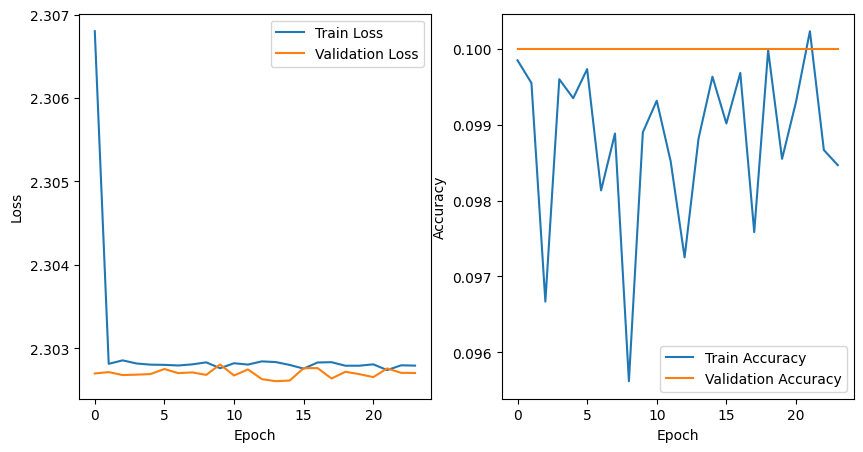

SGD done


Epoch [1/200], Train Loss: 2.305, Train Acc: 0.102, Val Loss: 2.305, Val Acc: 0.100


Epoch [2/200], Train Loss: 2.305, Train Acc: 0.099, Val Loss: 2.306, Val Acc: 0.100


Epoch [3/200], Train Loss: 2.304, Train Acc: 0.101, Val Loss: 2.306, Val Acc: 0.100


Epoch [4/200], Train Loss: 2.304, Train Acc: 0.100, Val Loss: 2.304, Val Acc: 0.100


Epoch [5/200], Train Loss: 2.305, Train Acc: 0.099, Val Loss: 2.304, Val Acc: 0.100


Epoch [6/200], Train Loss: 2.304, Train Acc: 0.100, Val Loss: 2.304, Val Acc: 0.100


Epoch [7/200], Train Loss: 2.304, Train Acc: 0.100, Val Loss: 2.304, Val Acc: 0.100


Epoch [8/200], Train Loss: 2.304, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [9/200], Train Loss: 2.304, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [10/200], Train Loss: 2.304, Train Acc: 0.102, Val Loss: 2.303, Val Acc: 0.100


Epoch [11/200], Train Loss: 2.304, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [12/200], Train Loss: 2.304, Train Acc: 0.102, Val Loss: 2.304, Val Acc: 0.100


Epoch [13/200], Train Loss: 2.304, Train Acc: 0.100, Val Loss: 2.304, Val Acc: 0.100


Epoch [14/200], Train Loss: 2.304, Train Acc: 0.099, Val Loss: 2.304, Val Acc: 0.100


Epoch [15/200], Train Loss: 2.304, Train Acc: 0.099, Val Loss: 2.305, Val Acc: 0.100


Epoch [16/200], Train Loss: 2.304, Train Acc: 0.101, Val Loss: 2.305, Val Acc: 0.100


Epoch [17/200], Train Loss: 2.304, Train Acc: 0.101, Val Loss: 2.304, Val Acc: 0.100


Epoch [18/200], Train Loss: 2.304, Train Acc: 0.100, Val Loss: 2.305, Val Acc: 0.100


Epoch [19/200], Train Loss: 2.304, Train Acc: 0.101, Val Loss: 2.304, Val Acc: 0.100


Epoch [20/200], Train Loss: 2.304, Train Acc: 0.100, Val Loss: 2.304, Val Acc: 0.100
Early stopping at epoch 20


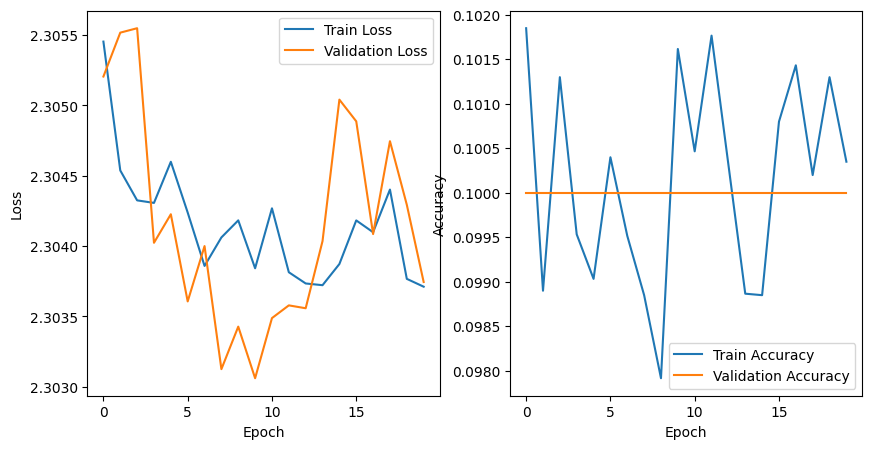

Momentum done


Epoch [1/200], Train Loss: 2.305, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [2/200], Train Loss: 2.304, Train Acc: 0.100, Val Loss: 2.305, Val Acc: 0.100


Epoch [3/200], Train Loss: 2.304, Train Acc: 0.098, Val Loss: 2.304, Val Acc: 0.100


Epoch [4/200], Train Loss: 2.304, Train Acc: 0.102, Val Loss: 2.304, Val Acc: 0.100


Epoch [5/200], Train Loss: 2.304, Train Acc: 0.101, Val Loss: 2.304, Val Acc: 0.100


Epoch [6/200], Train Loss: 2.304, Train Acc: 0.099, Val Loss: 2.304, Val Acc: 0.100


Epoch [7/200], Train Loss: 2.304, Train Acc: 0.101, Val Loss: 2.305, Val Acc: 0.100


Epoch [8/200], Train Loss: 2.304, Train Acc: 0.098, Val Loss: 2.304, Val Acc: 0.100


Epoch [9/200], Train Loss: 2.304, Train Acc: 0.099, Val Loss: 2.304, Val Acc: 0.100


Epoch [10/200], Train Loss: 2.304, Train Acc: 0.098, Val Loss: 2.304, Val Acc: 0.100


Epoch [11/200], Train Loss: 2.304, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100
Early stopping at epoch 11


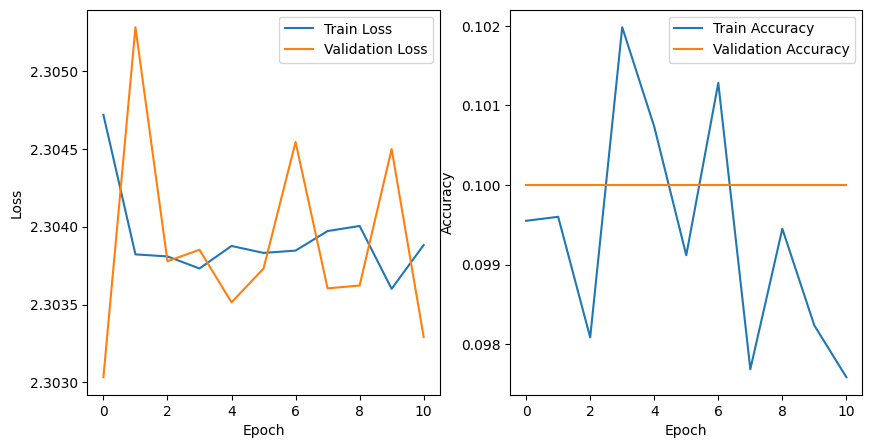

Nesterov done


Epoch [1/200], Train Loss: 1.569, Train Acc: 0.321, Val Loss: 1.266, Val Acc: 0.414


Epoch [2/200], Train Loss: 1.138, Train Acc: 0.494, Val Loss: 1.086, Val Acc: 0.538


Epoch [3/200], Train Loss: 0.984, Train Acc: 0.585, Val Loss: 0.936, Val Acc: 0.599


Epoch [4/200], Train Loss: 0.870, Train Acc: 0.631, Val Loss: 0.849, Val Acc: 0.630


Epoch [5/200], Train Loss: 0.790, Train Acc: 0.671, Val Loss: 0.806, Val Acc: 0.685


Epoch [6/200], Train Loss: 0.736, Train Acc: 0.694, Val Loss: 0.736, Val Acc: 0.682


Epoch [7/200], Train Loss: 0.692, Train Acc: 0.716, Val Loss: 0.714, Val Acc: 0.702


Epoch [8/200], Train Loss: 0.657, Train Acc: 0.763, Val Loss: 0.664, Val Acc: 0.786


Epoch [9/200], Train Loss: 0.592, Train Acc: 0.800, Val Loss: 0.603, Val Acc: 0.793


Epoch [10/200], Train Loss: 0.547, Train Acc: 0.807, Val Loss: 0.589, Val Acc: 0.785


Epoch [11/200], Train Loss: 0.524, Train Acc: 0.812, Val Loss: 0.549, Val Acc: 0.802


Epoch [12/200], Train Loss: 0.508, Train Acc: 0.817, Val Loss: 0.533, Val Acc: 0.809


Epoch [13/200], Train Loss: 0.494, Train Acc: 0.820, Val Loss: 0.523, Val Acc: 0.811


Epoch [14/200], Train Loss: 0.484, Train Acc: 0.824, Val Loss: 0.528, Val Acc: 0.810


Epoch [15/200], Train Loss: 0.475, Train Acc: 0.826, Val Loss: 0.528, Val Acc: 0.808


Epoch [16/200], Train Loss: 0.468, Train Acc: 0.828, Val Loss: 0.507, Val Acc: 0.814


Epoch [17/200], Train Loss: 0.461, Train Acc: 0.829, Val Loss: 0.497, Val Acc: 0.817


Epoch [18/200], Train Loss: 0.455, Train Acc: 0.832, Val Loss: 0.490, Val Acc: 0.819


Epoch [19/200], Train Loss: 0.448, Train Acc: 0.834, Val Loss: 0.484, Val Acc: 0.821


Epoch [20/200], Train Loss: 0.443, Train Acc: 0.836, Val Loss: 0.507, Val Acc: 0.809


Epoch [21/200], Train Loss: 0.439, Train Acc: 0.838, Val Loss: 0.524, Val Acc: 0.808


Epoch [22/200], Train Loss: 0.434, Train Acc: 0.840, Val Loss: 0.503, Val Acc: 0.813


Epoch [23/200], Train Loss: 0.428, Train Acc: 0.843, Val Loss: 0.473, Val Acc: 0.827


Epoch [24/200], Train Loss: 0.426, Train Acc: 0.844, Val Loss: 0.490, Val Acc: 0.819


Epoch [25/200], Train Loss: 0.419, Train Acc: 0.849, Val Loss: 0.481, Val Acc: 0.819


Epoch [26/200], Train Loss: 0.415, Train Acc: 0.851, Val Loss: 0.476, Val Acc: 0.827


Epoch [27/200], Train Loss: 0.410, Train Acc: 0.854, Val Loss: 0.455, Val Acc: 0.838


Epoch [28/200], Train Loss: 0.405, Train Acc: 0.856, Val Loss: 0.464, Val Acc: 0.833


Epoch [29/200], Train Loss: 0.401, Train Acc: 0.859, Val Loss: 0.452, Val Acc: 0.843


Epoch [30/200], Train Loss: 0.396, Train Acc: 0.862, Val Loss: 0.452, Val Acc: 0.839


Epoch [31/200], Train Loss: 0.391, Train Acc: 0.864, Val Loss: 0.445, Val Acc: 0.844


Epoch [32/200], Train Loss: 0.386, Train Acc: 0.867, Val Loss: 0.439, Val Acc: 0.847


Epoch [33/200], Train Loss: 0.383, Train Acc: 0.869, Val Loss: 0.464, Val Acc: 0.832


Epoch [34/200], Train Loss: 0.378, Train Acc: 0.870, Val Loss: 0.447, Val Acc: 0.845


Epoch [35/200], Train Loss: 0.376, Train Acc: 0.871, Val Loss: 0.428, Val Acc: 0.851


Epoch [36/200], Train Loss: 0.370, Train Acc: 0.872, Val Loss: 0.428, Val Acc: 0.852


Epoch [37/200], Train Loss: 0.367, Train Acc: 0.874, Val Loss: 0.433, Val Acc: 0.848


Epoch [38/200], Train Loss: 0.364, Train Acc: 0.875, Val Loss: 0.420, Val Acc: 0.855


Epoch [39/200], Train Loss: 0.362, Train Acc: 0.876, Val Loss: 0.444, Val Acc: 0.844


Epoch [40/200], Train Loss: 0.357, Train Acc: 0.877, Val Loss: 0.423, Val Acc: 0.854


Epoch [41/200], Train Loss: 0.355, Train Acc: 0.879, Val Loss: 0.431, Val Acc: 0.849


Epoch [42/200], Train Loss: 0.352, Train Acc: 0.880, Val Loss: 0.413, Val Acc: 0.858


Epoch [43/200], Train Loss: 0.350, Train Acc: 0.881, Val Loss: 0.419, Val Acc: 0.853


Epoch [44/200], Train Loss: 0.347, Train Acc: 0.882, Val Loss: 0.416, Val Acc: 0.858


Epoch [45/200], Train Loss: 0.345, Train Acc: 0.882, Val Loss: 0.419, Val Acc: 0.854


Epoch [46/200], Train Loss: 0.344, Train Acc: 0.883, Val Loss: 0.404, Val Acc: 0.861


Epoch [47/200], Train Loss: 0.340, Train Acc: 0.884, Val Loss: 0.409, Val Acc: 0.859


Epoch [48/200], Train Loss: 0.336, Train Acc: 0.885, Val Loss: 0.405, Val Acc: 0.860


Epoch [49/200], Train Loss: 0.335, Train Acc: 0.885, Val Loss: 0.409, Val Acc: 0.859


Epoch [50/200], Train Loss: 0.333, Train Acc: 0.887, Val Loss: 0.404, Val Acc: 0.860


Epoch [51/200], Train Loss: 0.331, Train Acc: 0.887, Val Loss: 0.401, Val Acc: 0.863


Epoch [52/200], Train Loss: 0.330, Train Acc: 0.888, Val Loss: 0.411, Val Acc: 0.860


Epoch [53/200], Train Loss: 0.327, Train Acc: 0.888, Val Loss: 0.412, Val Acc: 0.855


Epoch [54/200], Train Loss: 0.326, Train Acc: 0.889, Val Loss: 0.397, Val Acc: 0.862


Epoch [55/200], Train Loss: 0.323, Train Acc: 0.890, Val Loss: 0.422, Val Acc: 0.851


Epoch [56/200], Train Loss: 0.323, Train Acc: 0.890, Val Loss: 0.394, Val Acc: 0.864


Epoch [57/200], Train Loss: 0.320, Train Acc: 0.891, Val Loss: 0.393, Val Acc: 0.865


Epoch [58/200], Train Loss: 0.319, Train Acc: 0.891, Val Loss: 0.408, Val Acc: 0.859


Epoch [59/200], Train Loss: 0.318, Train Acc: 0.891, Val Loss: 0.390, Val Acc: 0.866


Epoch [60/200], Train Loss: 0.316, Train Acc: 0.892, Val Loss: 0.391, Val Acc: 0.865


Epoch [61/200], Train Loss: 0.314, Train Acc: 0.893, Val Loss: 0.405, Val Acc: 0.862


Epoch [62/200], Train Loss: 0.313, Train Acc: 0.894, Val Loss: 0.392, Val Acc: 0.865


Epoch [63/200], Train Loss: 0.311, Train Acc: 0.895, Val Loss: 0.408, Val Acc: 0.862


Epoch [64/200], Train Loss: 0.310, Train Acc: 0.894, Val Loss: 0.409, Val Acc: 0.856


Epoch [65/200], Train Loss: 0.309, Train Acc: 0.894, Val Loss: 0.389, Val Acc: 0.865


Epoch [66/200], Train Loss: 0.307, Train Acc: 0.896, Val Loss: 0.386, Val Acc: 0.866


Epoch [67/200], Train Loss: 0.306, Train Acc: 0.897, Val Loss: 0.389, Val Acc: 0.864


Epoch [68/200], Train Loss: 0.304, Train Acc: 0.896, Val Loss: 0.392, Val Acc: 0.864


Epoch [69/200], Train Loss: 0.303, Train Acc: 0.896, Val Loss: 0.383, Val Acc: 0.866


Epoch [70/200], Train Loss: 0.302, Train Acc: 0.896, Val Loss: 0.395, Val Acc: 0.861


Epoch [71/200], Train Loss: 0.300, Train Acc: 0.898, Val Loss: 0.404, Val Acc: 0.860


Epoch [72/200], Train Loss: 0.299, Train Acc: 0.899, Val Loss: 0.384, Val Acc: 0.867


Epoch [73/200], Train Loss: 0.300, Train Acc: 0.898, Val Loss: 0.382, Val Acc: 0.870


Epoch [74/200], Train Loss: 0.297, Train Acc: 0.899, Val Loss: 0.388, Val Acc: 0.866


Epoch [75/200], Train Loss: 0.296, Train Acc: 0.900, Val Loss: 0.382, Val Acc: 0.868


Epoch [76/200], Train Loss: 0.296, Train Acc: 0.899, Val Loss: 0.389, Val Acc: 0.865


Epoch [77/200], Train Loss: 0.294, Train Acc: 0.900, Val Loss: 0.404, Val Acc: 0.861


Epoch [78/200], Train Loss: 0.292, Train Acc: 0.900, Val Loss: 0.379, Val Acc: 0.871


Epoch [79/200], Train Loss: 0.292, Train Acc: 0.900, Val Loss: 0.383, Val Acc: 0.868


Epoch [80/200], Train Loss: 0.291, Train Acc: 0.901, Val Loss: 0.387, Val Acc: 0.866


Epoch [81/200], Train Loss: 0.289, Train Acc: 0.902, Val Loss: 0.390, Val Acc: 0.865


Epoch [82/200], Train Loss: 0.289, Train Acc: 0.902, Val Loss: 0.393, Val Acc: 0.866


Epoch [83/200], Train Loss: 0.288, Train Acc: 0.902, Val Loss: 0.386, Val Acc: 0.867


Epoch [84/200], Train Loss: 0.287, Train Acc: 0.903, Val Loss: 0.381, Val Acc: 0.870


Epoch [85/200], Train Loss: 0.286, Train Acc: 0.903, Val Loss: 0.401, Val Acc: 0.860


Epoch [86/200], Train Loss: 0.285, Train Acc: 0.903, Val Loss: 0.390, Val Acc: 0.863


Epoch [87/200], Train Loss: 0.285, Train Acc: 0.903, Val Loss: 0.413, Val Acc: 0.856


Epoch [88/200], Train Loss: 0.283, Train Acc: 0.904, Val Loss: 0.388, Val Acc: 0.869
Early stopping at epoch 88


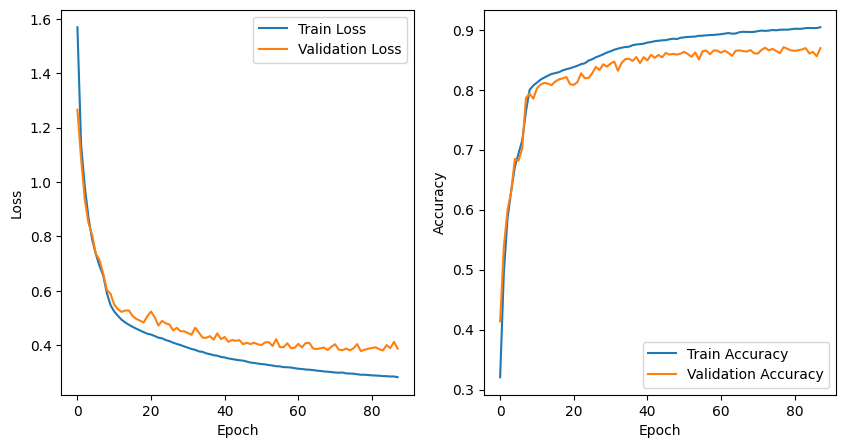

Adagrad done


Epoch [1/200], Train Loss: 1.469, Train Acc: 0.357, Val Loss: 1.091, Val Acc: 0.550


Epoch [2/200], Train Loss: 0.866, Train Acc: 0.641, Val Loss: 0.795, Val Acc: 0.677


Epoch [3/200], Train Loss: 0.632, Train Acc: 0.763, Val Loss: 0.654, Val Acc: 0.748


Epoch [4/200], Train Loss: 0.514, Train Acc: 0.818, Val Loss: 0.611, Val Acc: 0.789


Epoch [5/200], Train Loss: 0.456, Train Acc: 0.835, Val Loss: 0.569, Val Acc: 0.810


Epoch [6/200], Train Loss: 0.416, Train Acc: 0.849, Val Loss: 0.634, Val Acc: 0.774


Epoch [7/200], Train Loss: 0.392, Train Acc: 0.856, Val Loss: 0.488, Val Acc: 0.821


Epoch [8/200], Train Loss: 0.372, Train Acc: 0.863, Val Loss: 0.483, Val Acc: 0.823


Epoch [9/200], Train Loss: 0.354, Train Acc: 0.869, Val Loss: 0.455, Val Acc: 0.841


Epoch [10/200], Train Loss: 0.338, Train Acc: 0.874, Val Loss: 0.588, Val Acc: 0.790


Epoch [11/200], Train Loss: 0.331, Train Acc: 0.876, Val Loss: 0.428, Val Acc: 0.848


Epoch [12/200], Train Loss: 0.318, Train Acc: 0.881, Val Loss: 0.457, Val Acc: 0.838


Epoch [13/200], Train Loss: 0.312, Train Acc: 0.885, Val Loss: 0.546, Val Acc: 0.816


Epoch [14/200], Train Loss: 0.300, Train Acc: 0.887, Val Loss: 0.465, Val Acc: 0.844


Epoch [15/200], Train Loss: 0.293, Train Acc: 0.891, Val Loss: 0.402, Val Acc: 0.865


Epoch [16/200], Train Loss: 0.287, Train Acc: 0.893, Val Loss: 0.369, Val Acc: 0.870


Epoch [17/200], Train Loss: 0.277, Train Acc: 0.896, Val Loss: 0.392, Val Acc: 0.865


Epoch [18/200], Train Loss: 0.272, Train Acc: 0.898, Val Loss: 0.427, Val Acc: 0.863


Epoch [19/200], Train Loss: 0.269, Train Acc: 0.899, Val Loss: 0.461, Val Acc: 0.844


Epoch [20/200], Train Loss: 0.264, Train Acc: 0.901, Val Loss: 0.406, Val Acc: 0.866


Epoch [21/200], Train Loss: 0.260, Train Acc: 0.902, Val Loss: 0.429, Val Acc: 0.860


Epoch [22/200], Train Loss: 0.253, Train Acc: 0.904, Val Loss: 0.397, Val Acc: 0.869


Epoch [23/200], Train Loss: 0.250, Train Acc: 0.906, Val Loss: 0.416, Val Acc: 0.868


Epoch [24/200], Train Loss: 0.245, Train Acc: 0.907, Val Loss: 0.405, Val Acc: 0.874


Epoch [25/200], Train Loss: 0.239, Train Acc: 0.911, Val Loss: 0.433, Val Acc: 0.856


Epoch [26/200], Train Loss: 0.238, Train Acc: 0.911, Val Loss: 0.376, Val Acc: 0.875
Early stopping at epoch 26


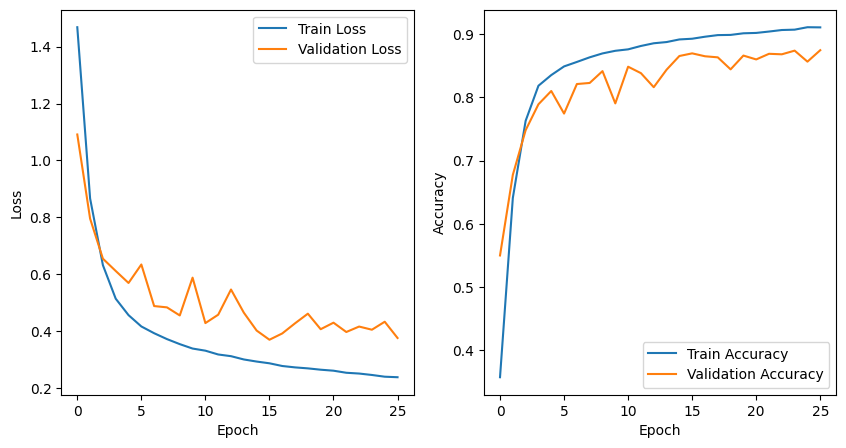

RMSprop done


Epoch [1/200], Train Loss: 1.385, Train Acc: 0.409, Val Loss: 0.911, Val Acc: 0.649


Epoch [2/200], Train Loss: 0.677, Train Acc: 0.729, Val Loss: 0.570, Val Acc: 0.787


Epoch [3/200], Train Loss: 0.450, Train Acc: 0.841, Val Loss: 0.463, Val Acc: 0.838


Epoch [4/200], Train Loss: 0.384, Train Acc: 0.863, Val Loss: 0.414, Val Acc: 0.848


Epoch [5/200], Train Loss: 0.353, Train Acc: 0.872, Val Loss: 0.404, Val Acc: 0.852


Epoch [6/200], Train Loss: 0.330, Train Acc: 0.881, Val Loss: 0.416, Val Acc: 0.851


Epoch [7/200], Train Loss: 0.330, Train Acc: 0.879, Val Loss: 0.396, Val Acc: 0.857


Epoch [8/200], Train Loss: 0.313, Train Acc: 0.886, Val Loss: 0.374, Val Acc: 0.867


Epoch [9/200], Train Loss: 0.295, Train Acc: 0.891, Val Loss: 0.378, Val Acc: 0.864


Epoch [10/200], Train Loss: 0.295, Train Acc: 0.891, Val Loss: 0.384, Val Acc: 0.858


Epoch [11/200], Train Loss: 0.285, Train Acc: 0.894, Val Loss: 0.364, Val Acc: 0.872


Epoch [12/200], Train Loss: 0.282, Train Acc: 0.896, Val Loss: 0.374, Val Acc: 0.872


Epoch [13/200], Train Loss: 0.269, Train Acc: 0.901, Val Loss: 0.361, Val Acc: 0.873


Epoch [14/200], Train Loss: 0.260, Train Acc: 0.903, Val Loss: 0.363, Val Acc: 0.873


Epoch [15/200], Train Loss: 0.259, Train Acc: 0.904, Val Loss: 0.375, Val Acc: 0.871


Epoch [16/200], Train Loss: 0.254, Train Acc: 0.906, Val Loss: 0.384, Val Acc: 0.867


Epoch [17/200], Train Loss: 0.252, Train Acc: 0.905, Val Loss: 0.363, Val Acc: 0.877


Epoch [18/200], Train Loss: 0.244, Train Acc: 0.910, Val Loss: 0.366, Val Acc: 0.869


Epoch [19/200], Train Loss: 0.236, Train Acc: 0.912, Val Loss: 0.371, Val Acc: 0.871


Epoch [20/200], Train Loss: 0.233, Train Acc: 0.913, Val Loss: 0.403, Val Acc: 0.864


Epoch [21/200], Train Loss: 0.239, Train Acc: 0.911, Val Loss: 0.358, Val Acc: 0.878


Epoch [22/200], Train Loss: 0.231, Train Acc: 0.915, Val Loss: 0.355, Val Acc: 0.878


Epoch [23/200], Train Loss: 0.234, Train Acc: 0.914, Val Loss: 0.376, Val Acc: 0.873


Epoch [24/200], Train Loss: 0.232, Train Acc: 0.914, Val Loss: 0.375, Val Acc: 0.871


Epoch [25/200], Train Loss: 0.228, Train Acc: 0.916, Val Loss: 0.383, Val Acc: 0.879


Epoch [26/200], Train Loss: 0.224, Train Acc: 0.918, Val Loss: 0.397, Val Acc: 0.870


Epoch [27/200], Train Loss: 0.222, Train Acc: 0.918, Val Loss: 0.384, Val Acc: 0.873


Epoch [28/200], Train Loss: 0.218, Train Acc: 0.919, Val Loss: 0.384, Val Acc: 0.877


Epoch [29/200], Train Loss: 0.210, Train Acc: 0.921, Val Loss: 0.377, Val Acc: 0.876


Epoch [30/200], Train Loss: 0.213, Train Acc: 0.921, Val Loss: 0.400, Val Acc: 0.875


Epoch [31/200], Train Loss: 0.212, Train Acc: 0.921, Val Loss: 0.384, Val Acc: 0.872


Epoch [32/200], Train Loss: 0.209, Train Acc: 0.923, Val Loss: 0.401, Val Acc: 0.875
Early stopping at epoch 32


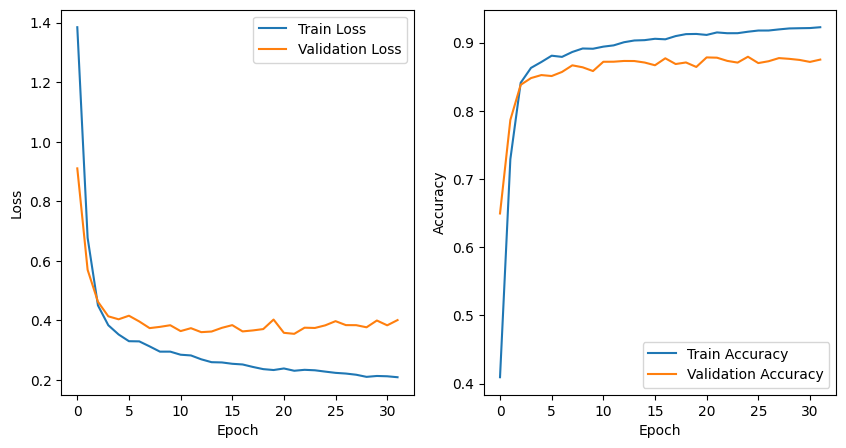

Adam done


Epoch [1/200], Train Loss: 4.812, Train Acc: 0.103, Val Loss: 2.308, Val Acc: 0.100


Epoch [2/200], Train Loss: 2.307, Train Acc: 0.101, Val Loss: 2.309, Val Acc: 0.100


Epoch [3/200], Train Loss: 2.308, Train Acc: 0.101, Val Loss: 2.305, Val Acc: 0.100


Epoch [4/200], Train Loss: 2.307, Train Acc: 0.098, Val Loss: 2.308, Val Acc: 0.100


Epoch [5/200], Train Loss: 2.307, Train Acc: 0.102, Val Loss: 2.309, Val Acc: 0.100


Epoch [6/200], Train Loss: 2.307, Train Acc: 0.100, Val Loss: 2.306, Val Acc: 0.100


Epoch [7/200], Train Loss: 2.306, Train Acc: 0.101, Val Loss: 2.306, Val Acc: 0.100


Epoch [8/200], Train Loss: 2.307, Train Acc: 0.099, Val Loss: 2.307, Val Acc: 0.100


Epoch [9/200], Train Loss: 2.308, Train Acc: 0.099, Val Loss: 2.307, Val Acc: 0.100


Epoch [10/200], Train Loss: 2.306, Train Acc: 0.100, Val Loss: 2.304, Val Acc: 0.100


Epoch [11/200], Train Loss: 2.308, Train Acc: 0.098, Val Loss: 2.307, Val Acc: 0.100


Epoch [12/200], Train Loss: 2.306, Train Acc: 0.098, Val Loss: 2.308, Val Acc: 0.100


Epoch [13/200], Train Loss: 2.306, Train Acc: 0.101, Val Loss: 2.304, Val Acc: 0.100


Epoch [14/200], Train Loss: 2.307, Train Acc: 0.100, Val Loss: 2.306, Val Acc: 0.100


Epoch [15/200], Train Loss: 2.306, Train Acc: 0.101, Val Loss: 2.306, Val Acc: 0.100


Epoch [16/200], Train Loss: 2.306, Train Acc: 0.099, Val Loss: 2.308, Val Acc: 0.100


Epoch [17/200], Train Loss: 2.308, Train Acc: 0.101, Val Loss: 2.311, Val Acc: 0.100


Epoch [18/200], Train Loss: 2.307, Train Acc: 0.101, Val Loss: 2.308, Val Acc: 0.100


Epoch [19/200], Train Loss: 2.307, Train Acc: 0.097, Val Loss: 2.308, Val Acc: 0.100


Epoch [20/200], Train Loss: 2.307, Train Acc: 0.103, Val Loss: 2.308, Val Acc: 0.100
Early stopping at epoch 20


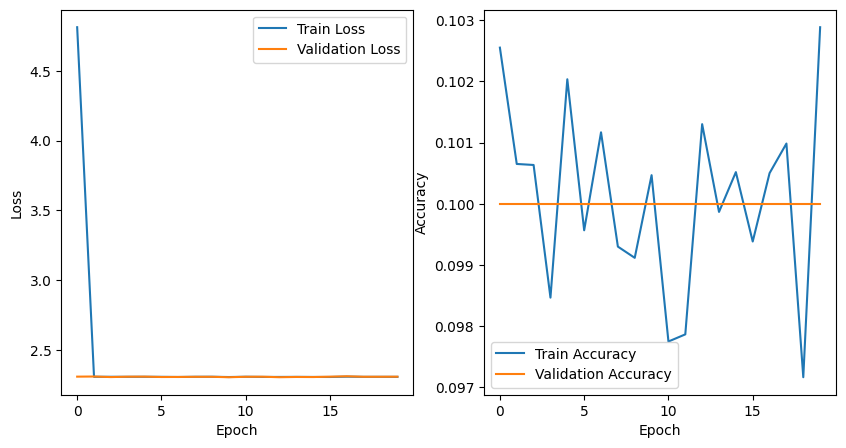

ADOPT done


In [9]:
optimizers = ['SGD', 'Momentum', 'Nesterov', 'Adagrad', 'RMSprop', 'Adam', 'ADOPT']
for optim_name in optimizers:
    train_losses, train_acc, val_losses, val_acc = train(train_loader, test_loader, optim_name, num_epochs, lr)
    plot(train_losses, train_acc, val_losses, val_acc)
    torch.save(train_losses, f'{optim_name}_train_losses.pt')
    torch.save(train_acc, f'{optim_name}_train_acc.pt')
    torch.save(val_losses, f'{optim_name}_val_losses.pt')
    torch.save(val_acc, f'{optim_name}_val_acc.pt')
    print(f'{optim_name} done')
    print('='*50)

<ipython-input-14-d41e946aa15b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_losses = [torch.load(f'{optim_name}_train_losses.pt') for optim_name in optimizers]
<i

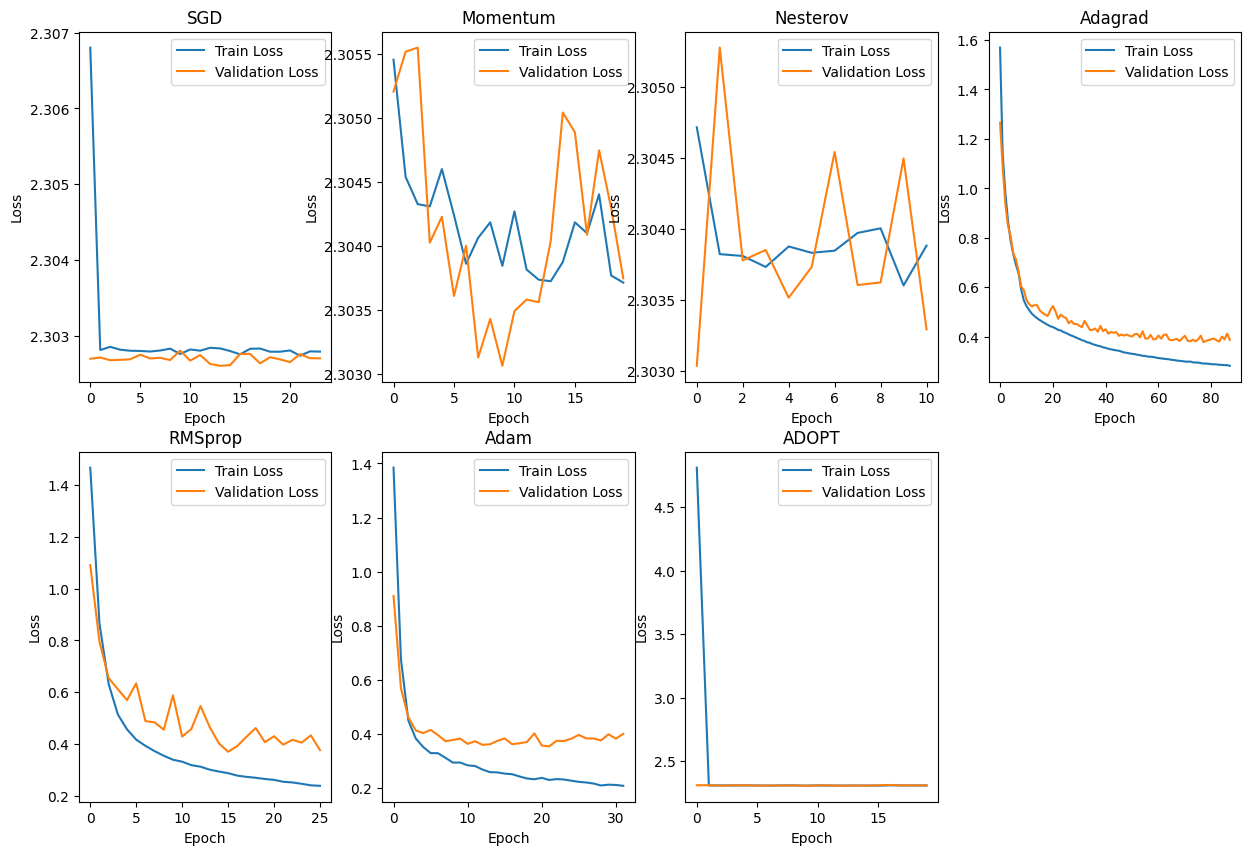

In [14]:
train_losses = [torch.load(f'{optim_name}_train_losses.pt') for optim_name in optimizers]
train_acc = [torch.load(f'{optim_name}_train_acc.pt') for optim_name in optimizers]
val_losses = [torch.load(f'{optim_name}_val_losses.pt') for optim_name in optimizers]
val_acc = [torch.load(f'{optim_name}_val_acc.pt') for optim_name in optimizers]

plt.figure(figsize=(15, 10))
for i in range(len(optimizers)):
    plt.subplot(2, 4, i+1)
    plt.plot(train_losses[i], label='Train Loss')
    plt.plot(val_losses[i], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(optimizers[i])
    plt.legend()
plt.show()

Epoch [1/200], Train Loss: 2.321, Train Acc: 0.100, Val Loss: 2.314, Val Acc: 0.100


Epoch [2/200], Train Loss: 2.310, Train Acc: 0.100, Val Loss: 2.308, Val Acc: 0.100


Epoch [3/200], Train Loss: 2.306, Train Acc: 0.100, Val Loss: 2.305, Val Acc: 0.100


Epoch [4/200], Train Loss: 2.304, Train Acc: 0.100, Val Loss: 2.304, Val Acc: 0.100


Epoch [5/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [6/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [7/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [8/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [9/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [10/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [11/200], Train Loss: 2.303, Train Acc: 0.096, Val Loss: 2.303, Val Acc: 0.100


Epoch [12/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [13/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [14/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.077


Epoch [15/200], Train Loss: 2.303, Train Acc: 0.097, Val Loss: 2.303, Val Acc: 0.100


Epoch [16/200], Train Loss: 2.303, Train Acc: 0.096, Val Loss: 2.303, Val Acc: 0.100


Epoch [17/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [18/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.064


Epoch [19/200], Train Loss: 2.303, Train Acc: 0.097, Val Loss: 2.303, Val Acc: 0.100


Epoch [20/200], Train Loss: 2.303, Train Acc: 0.097, Val Loss: 2.303, Val Acc: 0.107


Epoch [21/200], Train Loss: 2.303, Train Acc: 0.097, Val Loss: 2.303, Val Acc: 0.108


Epoch [22/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.090


Epoch [23/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.092


Epoch [24/200], Train Loss: 2.303, Train Acc: 0.097, Val Loss: 2.303, Val Acc: 0.100


Epoch [25/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [26/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [27/200], Train Loss: 2.303, Train Acc: 0.096, Val Loss: 2.303, Val Acc: 0.100


Epoch [28/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [29/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [30/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.101


Epoch [31/200], Train Loss: 2.303, Train Acc: 0.096, Val Loss: 2.303, Val Acc: 0.100


Epoch [32/200], Train Loss: 2.303, Train Acc: 0.097, Val Loss: 2.303, Val Acc: 0.100
Early stopping at epoch 32


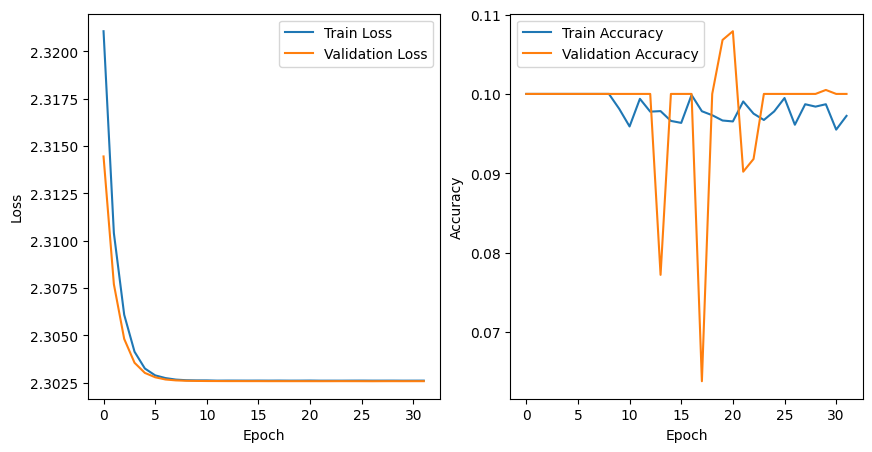

SGD done


Epoch [1/200], Train Loss: 2.312, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [2/200], Train Loss: 2.303, Train Acc: 0.101, Val Loss: 2.303, Val Acc: 0.100


Epoch [3/200], Train Loss: 2.303, Train Acc: 0.097, Val Loss: 2.303, Val Acc: 0.100


Epoch [4/200], Train Loss: 2.303, Train Acc: 0.097, Val Loss: 2.303, Val Acc: 0.100


Epoch [5/200], Train Loss: 2.303, Train Acc: 0.095, Val Loss: 2.303, Val Acc: 0.100


Epoch [6/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [7/200], Train Loss: 2.303, Train Acc: 0.101, Val Loss: 2.303, Val Acc: 0.100
Early stopping at epoch 7


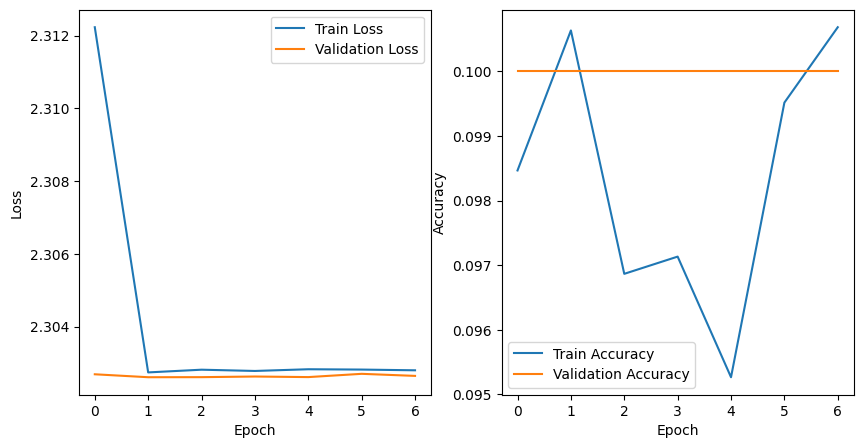

Momentum done


Epoch [1/200], Train Loss: 2.310, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [2/200], Train Loss: 2.303, Train Acc: 0.096, Val Loss: 2.303, Val Acc: 0.100


Epoch [3/200], Train Loss: 2.303, Train Acc: 0.100, Val Loss: 2.303, Val Acc: 0.100


Epoch [4/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [5/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [6/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [7/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [8/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100


Epoch [9/200], Train Loss: 2.303, Train Acc: 0.098, Val Loss: 2.303, Val Acc: 0.100


Epoch [10/200], Train Loss: 2.303, Train Acc: 0.099, Val Loss: 2.303, Val Acc: 0.100
Early stopping at epoch 10


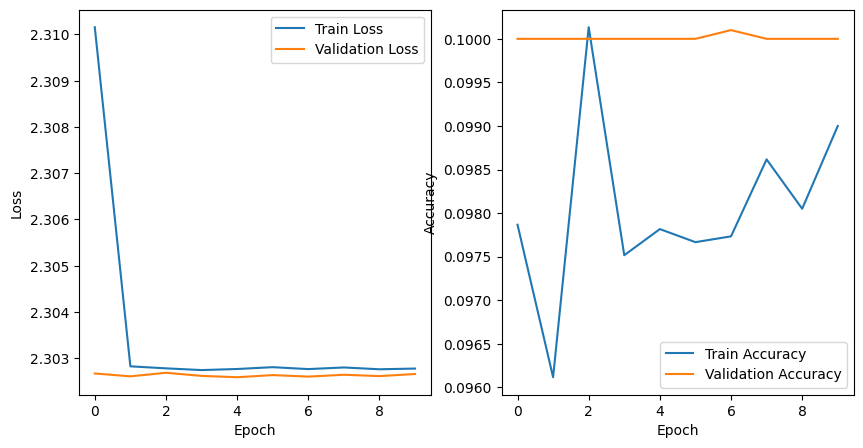

Nesterov done


Epoch [1/200], Train Loss: 2.300, Train Acc: 0.157, Val Loss: 2.283, Val Acc: 0.178


Epoch [2/200], Train Loss: 2.218, Train Acc: 0.210, Val Loss: 2.118, Val Acc: 0.218


Epoch [3/200], Train Loss: 1.999, Train Acc: 0.209, Val Loss: 1.897, Val Acc: 0.210


Epoch [4/200], Train Loss: 1.835, Train Acc: 0.210, Val Loss: 1.791, Val Acc: 0.212


Epoch [5/200], Train Loss: 1.763, Train Acc: 0.215, Val Loss: 1.743, Val Acc: 0.219


Epoch [6/200], Train Loss: 1.726, Train Acc: 0.227, Val Loss: 1.716, Val Acc: 0.190


Epoch [7/200], Train Loss: 1.702, Train Acc: 0.252, Val Loss: 1.692, Val Acc: 0.278


Epoch [8/200], Train Loss: 1.678, Train Acc: 0.292, Val Loss: 1.665, Val Acc: 0.256


Epoch [9/200], Train Loss: 1.652, Train Acc: 0.301, Val Loss: 1.638, Val Acc: 0.341


Epoch [10/200], Train Loss: 1.624, Train Acc: 0.330, Val Loss: 1.612, Val Acc: 0.312


Epoch [11/200], Train Loss: 1.600, Train Acc: 0.325, Val Loss: 1.590, Val Acc: 0.326


Epoch [12/200], Train Loss: 1.579, Train Acc: 0.329, Val Loss: 1.571, Val Acc: 0.324


Epoch [13/200], Train Loss: 1.561, Train Acc: 0.331, Val Loss: 1.554, Val Acc: 0.322


Epoch [14/200], Train Loss: 1.547, Train Acc: 0.334, Val Loss: 1.541, Val Acc: 0.325


Epoch [15/200], Train Loss: 1.534, Train Acc: 0.329, Val Loss: 1.530, Val Acc: 0.331


Epoch [16/200], Train Loss: 1.524, Train Acc: 0.339, Val Loss: 1.520, Val Acc: 0.328


Epoch [17/200], Train Loss: 1.515, Train Acc: 0.332, Val Loss: 1.512, Val Acc: 0.340


Epoch [18/200], Train Loss: 1.508, Train Acc: 0.336, Val Loss: 1.505, Val Acc: 0.344


Epoch [19/200], Train Loss: 1.502, Train Acc: 0.343, Val Loss: 1.499, Val Acc: 0.359


Epoch [20/200], Train Loss: 1.496, Train Acc: 0.348, Val Loss: 1.494, Val Acc: 0.339


Epoch [21/200], Train Loss: 1.491, Train Acc: 0.349, Val Loss: 1.489, Val Acc: 0.346


Epoch [22/200], Train Loss: 1.486, Train Acc: 0.345, Val Loss: 1.485, Val Acc: 0.352


Epoch [23/200], Train Loss: 1.483, Train Acc: 0.366, Val Loss: 1.481, Val Acc: 0.346


Epoch [24/200], Train Loss: 1.479, Train Acc: 0.357, Val Loss: 1.478, Val Acc: 0.353


Epoch [25/200], Train Loss: 1.475, Train Acc: 0.357, Val Loss: 1.475, Val Acc: 0.394


Epoch [26/200], Train Loss: 1.472, Train Acc: 0.377, Val Loss: 1.471, Val Acc: 0.389


Epoch [27/200], Train Loss: 1.469, Train Acc: 0.384, Val Loss: 1.467, Val Acc: 0.400


Epoch [28/200], Train Loss: 1.464, Train Acc: 0.390, Val Loss: 1.462, Val Acc: 0.391


Epoch [29/200], Train Loss: 1.457, Train Acc: 0.405, Val Loss: 1.455, Val Acc: 0.426


Epoch [30/200], Train Loss: 1.450, Train Acc: 0.411, Val Loss: 1.446, Val Acc: 0.423


Epoch [31/200], Train Loss: 1.439, Train Acc: 0.420, Val Loss: 1.435, Val Acc: 0.422


Epoch [32/200], Train Loss: 1.428, Train Acc: 0.414, Val Loss: 1.422, Val Acc: 0.422


Epoch [33/200], Train Loss: 1.414, Train Acc: 0.416, Val Loss: 1.408, Val Acc: 0.431


Epoch [34/200], Train Loss: 1.400, Train Acc: 0.418, Val Loss: 1.395, Val Acc: 0.419


Epoch [35/200], Train Loss: 1.385, Train Acc: 0.421, Val Loss: 1.381, Val Acc: 0.454


Epoch [36/200], Train Loss: 1.371, Train Acc: 0.445, Val Loss: 1.367, Val Acc: 0.468


Epoch [37/200], Train Loss: 1.357, Train Acc: 0.456, Val Loss: 1.354, Val Acc: 0.454


Epoch [38/200], Train Loss: 1.345, Train Acc: 0.446, Val Loss: 1.343, Val Acc: 0.456


Epoch [39/200], Train Loss: 1.334, Train Acc: 0.450, Val Loss: 1.332, Val Acc: 0.468


Epoch [40/200], Train Loss: 1.323, Train Acc: 0.462, Val Loss: 1.322, Val Acc: 0.449


Epoch [41/200], Train Loss: 1.313, Train Acc: 0.450, Val Loss: 1.313, Val Acc: 0.453


Epoch [42/200], Train Loss: 1.304, Train Acc: 0.459, Val Loss: 1.305, Val Acc: 0.452


Epoch [43/200], Train Loss: 1.295, Train Acc: 0.459, Val Loss: 1.297, Val Acc: 0.455


Epoch [44/200], Train Loss: 1.287, Train Acc: 0.456, Val Loss: 1.290, Val Acc: 0.459


Epoch [45/200], Train Loss: 1.279, Train Acc: 0.462, Val Loss: 1.283, Val Acc: 0.455


Epoch [46/200], Train Loss: 1.272, Train Acc: 0.457, Val Loss: 1.276, Val Acc: 0.473


Epoch [47/200], Train Loss: 1.266, Train Acc: 0.469, Val Loss: 1.270, Val Acc: 0.467


Epoch [48/200], Train Loss: 1.259, Train Acc: 0.470, Val Loss: 1.264, Val Acc: 0.478


Epoch [49/200], Train Loss: 1.253, Train Acc: 0.473, Val Loss: 1.258, Val Acc: 0.476


Epoch [50/200], Train Loss: 1.248, Train Acc: 0.480, Val Loss: 1.252, Val Acc: 0.473


Epoch [51/200], Train Loss: 1.241, Train Acc: 0.480, Val Loss: 1.247, Val Acc: 0.474


Epoch [52/200], Train Loss: 1.236, Train Acc: 0.477, Val Loss: 1.241, Val Acc: 0.476


Epoch [53/200], Train Loss: 1.230, Train Acc: 0.483, Val Loss: 1.236, Val Acc: 0.481


Epoch [54/200], Train Loss: 1.224, Train Acc: 0.489, Val Loss: 1.230, Val Acc: 0.484


Epoch [55/200], Train Loss: 1.218, Train Acc: 0.492, Val Loss: 1.225, Val Acc: 0.485


Epoch [56/200], Train Loss: 1.213, Train Acc: 0.493, Val Loss: 1.220, Val Acc: 0.493


Epoch [57/200], Train Loss: 1.208, Train Acc: 0.500, Val Loss: 1.214, Val Acc: 0.498


Epoch [58/200], Train Loss: 1.201, Train Acc: 0.502, Val Loss: 1.208, Val Acc: 0.505


Epoch [59/200], Train Loss: 1.195, Train Acc: 0.518, Val Loss: 1.203, Val Acc: 0.505


Epoch [60/200], Train Loss: 1.190, Train Acc: 0.512, Val Loss: 1.197, Val Acc: 0.515


Epoch [61/200], Train Loss: 1.184, Train Acc: 0.522, Val Loss: 1.191, Val Acc: 0.521


Epoch [62/200], Train Loss: 1.179, Train Acc: 0.527, Val Loss: 1.186, Val Acc: 0.523


Epoch [63/200], Train Loss: 1.173, Train Acc: 0.529, Val Loss: 1.180, Val Acc: 0.549


Epoch [64/200], Train Loss: 1.167, Train Acc: 0.540, Val Loss: 1.175, Val Acc: 0.536


Epoch [65/200], Train Loss: 1.161, Train Acc: 0.538, Val Loss: 1.169, Val Acc: 0.536


Epoch [66/200], Train Loss: 1.156, Train Acc: 0.545, Val Loss: 1.163, Val Acc: 0.535


Epoch [67/200], Train Loss: 1.150, Train Acc: 0.544, Val Loss: 1.158, Val Acc: 0.551


Epoch [68/200], Train Loss: 1.145, Train Acc: 0.550, Val Loss: 1.152, Val Acc: 0.547


Epoch [69/200], Train Loss: 1.139, Train Acc: 0.553, Val Loss: 1.147, Val Acc: 0.547


Epoch [70/200], Train Loss: 1.134, Train Acc: 0.555, Val Loss: 1.142, Val Acc: 0.556


Epoch [71/200], Train Loss: 1.128, Train Acc: 0.562, Val Loss: 1.137, Val Acc: 0.561


Epoch [72/200], Train Loss: 1.123, Train Acc: 0.562, Val Loss: 1.132, Val Acc: 0.550


Epoch [73/200], Train Loss: 1.118, Train Acc: 0.560, Val Loss: 1.127, Val Acc: 0.551


Epoch [74/200], Train Loss: 1.114, Train Acc: 0.561, Val Loss: 1.122, Val Acc: 0.576


Epoch [75/200], Train Loss: 1.109, Train Acc: 0.568, Val Loss: 1.117, Val Acc: 0.556


Epoch [76/200], Train Loss: 1.104, Train Acc: 0.570, Val Loss: 1.113, Val Acc: 0.564


Epoch [77/200], Train Loss: 1.099, Train Acc: 0.573, Val Loss: 1.108, Val Acc: 0.561


Epoch [78/200], Train Loss: 1.094, Train Acc: 0.574, Val Loss: 1.104, Val Acc: 0.562


Epoch [79/200], Train Loss: 1.090, Train Acc: 0.568, Val Loss: 1.099, Val Acc: 0.585


Epoch [80/200], Train Loss: 1.086, Train Acc: 0.574, Val Loss: 1.095, Val Acc: 0.577


Epoch [81/200], Train Loss: 1.082, Train Acc: 0.576, Val Loss: 1.091, Val Acc: 0.592


Epoch [82/200], Train Loss: 1.077, Train Acc: 0.583, Val Loss: 1.087, Val Acc: 0.576


Epoch [83/200], Train Loss: 1.073, Train Acc: 0.581, Val Loss: 1.083, Val Acc: 0.570


Epoch [84/200], Train Loss: 1.070, Train Acc: 0.579, Val Loss: 1.079, Val Acc: 0.570


Epoch [85/200], Train Loss: 1.066, Train Acc: 0.579, Val Loss: 1.075, Val Acc: 0.598


Epoch [86/200], Train Loss: 1.062, Train Acc: 0.586, Val Loss: 1.072, Val Acc: 0.574


Epoch [87/200], Train Loss: 1.058, Train Acc: 0.584, Val Loss: 1.068, Val Acc: 0.572


Epoch [88/200], Train Loss: 1.055, Train Acc: 0.582, Val Loss: 1.065, Val Acc: 0.575


Epoch [89/200], Train Loss: 1.051, Train Acc: 0.587, Val Loss: 1.061, Val Acc: 0.575


Epoch [90/200], Train Loss: 1.047, Train Acc: 0.584, Val Loss: 1.058, Val Acc: 0.574


Epoch [91/200], Train Loss: 1.044, Train Acc: 0.590, Val Loss: 1.055, Val Acc: 0.576


Epoch [92/200], Train Loss: 1.042, Train Acc: 0.584, Val Loss: 1.052, Val Acc: 0.578


Epoch [93/200], Train Loss: 1.037, Train Acc: 0.587, Val Loss: 1.048, Val Acc: 0.580


Epoch [94/200], Train Loss: 1.034, Train Acc: 0.589, Val Loss: 1.045, Val Acc: 0.577


Epoch [95/200], Train Loss: 1.031, Train Acc: 0.588, Val Loss: 1.042, Val Acc: 0.580


Epoch [96/200], Train Loss: 1.028, Train Acc: 0.589, Val Loss: 1.039, Val Acc: 0.605


Epoch [97/200], Train Loss: 1.024, Train Acc: 0.594, Val Loss: 1.036, Val Acc: 0.598


Epoch [98/200], Train Loss: 1.022, Train Acc: 0.591, Val Loss: 1.033, Val Acc: 0.583


Epoch [99/200], Train Loss: 1.019, Train Acc: 0.591, Val Loss: 1.030, Val Acc: 0.583


Epoch [100/200], Train Loss: 1.016, Train Acc: 0.598, Val Loss: 1.028, Val Acc: 0.585


Epoch [101/200], Train Loss: 1.013, Train Acc: 0.592, Val Loss: 1.025, Val Acc: 0.586


Epoch [102/200], Train Loss: 1.011, Train Acc: 0.599, Val Loss: 1.023, Val Acc: 0.586


Epoch [103/200], Train Loss: 1.008, Train Acc: 0.594, Val Loss: 1.020, Val Acc: 0.594


Epoch [104/200], Train Loss: 1.005, Train Acc: 0.598, Val Loss: 1.017, Val Acc: 0.589


Epoch [105/200], Train Loss: 1.002, Train Acc: 0.597, Val Loss: 1.015, Val Acc: 0.591


Epoch [106/200], Train Loss: 1.000, Train Acc: 0.598, Val Loss: 1.012, Val Acc: 0.590


Epoch [107/200], Train Loss: 0.998, Train Acc: 0.598, Val Loss: 1.010, Val Acc: 0.590


Epoch [108/200], Train Loss: 0.995, Train Acc: 0.599, Val Loss: 1.007, Val Acc: 0.592


Epoch [109/200], Train Loss: 0.994, Train Acc: 0.603, Val Loss: 1.005, Val Acc: 0.594


Epoch [110/200], Train Loss: 0.991, Train Acc: 0.601, Val Loss: 1.003, Val Acc: 0.599


Epoch [111/200], Train Loss: 0.988, Train Acc: 0.605, Val Loss: 1.000, Val Acc: 0.597


Epoch [112/200], Train Loss: 0.986, Train Acc: 0.604, Val Loss: 0.998, Val Acc: 0.605


Epoch [113/200], Train Loss: 0.984, Train Acc: 0.610, Val Loss: 0.996, Val Acc: 0.599


Epoch [114/200], Train Loss: 0.982, Train Acc: 0.607, Val Loss: 0.994, Val Acc: 0.597


Epoch [115/200], Train Loss: 0.979, Train Acc: 0.608, Val Loss: 0.992, Val Acc: 0.597


Epoch [116/200], Train Loss: 0.977, Train Acc: 0.610, Val Loss: 0.990, Val Acc: 0.596


Epoch [117/200], Train Loss: 0.975, Train Acc: 0.608, Val Loss: 0.988, Val Acc: 0.596


Epoch [118/200], Train Loss: 0.974, Train Acc: 0.607, Val Loss: 0.985, Val Acc: 0.601


Epoch [119/200], Train Loss: 0.972, Train Acc: 0.608, Val Loss: 0.984, Val Acc: 0.601


Epoch [120/200], Train Loss: 0.969, Train Acc: 0.613, Val Loss: 0.982, Val Acc: 0.602


Epoch [121/200], Train Loss: 0.967, Train Acc: 0.612, Val Loss: 0.980, Val Acc: 0.603


Epoch [122/200], Train Loss: 0.964, Train Acc: 0.612, Val Loss: 0.978, Val Acc: 0.602


Epoch [123/200], Train Loss: 0.963, Train Acc: 0.611, Val Loss: 0.976, Val Acc: 0.603


Epoch [124/200], Train Loss: 0.961, Train Acc: 0.613, Val Loss: 0.974, Val Acc: 0.603


Epoch [125/200], Train Loss: 0.958, Train Acc: 0.613, Val Loss: 0.972, Val Acc: 0.605


Epoch [126/200], Train Loss: 0.957, Train Acc: 0.613, Val Loss: 0.970, Val Acc: 0.608


Epoch [127/200], Train Loss: 0.956, Train Acc: 0.620, Val Loss: 0.968, Val Acc: 0.607


Epoch [128/200], Train Loss: 0.954, Train Acc: 0.615, Val Loss: 0.966, Val Acc: 0.611


Epoch [129/200], Train Loss: 0.952, Train Acc: 0.625, Val Loss: 0.965, Val Acc: 0.612


Epoch [130/200], Train Loss: 0.950, Train Acc: 0.617, Val Loss: 0.963, Val Acc: 0.613


Epoch [131/200], Train Loss: 0.948, Train Acc: 0.618, Val Loss: 0.961, Val Acc: 0.613


Epoch [132/200], Train Loss: 0.946, Train Acc: 0.623, Val Loss: 0.959, Val Acc: 0.613


Epoch [133/200], Train Loss: 0.945, Train Acc: 0.629, Val Loss: 0.958, Val Acc: 0.614


Epoch [134/200], Train Loss: 0.943, Train Acc: 0.620, Val Loss: 0.956, Val Acc: 0.615


Epoch [135/200], Train Loss: 0.941, Train Acc: 0.622, Val Loss: 0.954, Val Acc: 0.616


Epoch [136/200], Train Loss: 0.940, Train Acc: 0.623, Val Loss: 0.952, Val Acc: 0.617


Epoch [137/200], Train Loss: 0.937, Train Acc: 0.625, Val Loss: 0.951, Val Acc: 0.618


Epoch [138/200], Train Loss: 0.936, Train Acc: 0.631, Val Loss: 0.949, Val Acc: 0.619


Epoch [139/200], Train Loss: 0.934, Train Acc: 0.629, Val Loss: 0.948, Val Acc: 0.620


Epoch [140/200], Train Loss: 0.933, Train Acc: 0.627, Val Loss: 0.946, Val Acc: 0.622


Epoch [141/200], Train Loss: 0.931, Train Acc: 0.626, Val Loss: 0.944, Val Acc: 0.623


Epoch [142/200], Train Loss: 0.929, Train Acc: 0.627, Val Loss: 0.943, Val Acc: 0.626


Epoch [143/200], Train Loss: 0.928, Train Acc: 0.631, Val Loss: 0.941, Val Acc: 0.625


Epoch [144/200], Train Loss: 0.926, Train Acc: 0.630, Val Loss: 0.940, Val Acc: 0.630


Epoch [145/200], Train Loss: 0.925, Train Acc: 0.634, Val Loss: 0.938, Val Acc: 0.628


Epoch [146/200], Train Loss: 0.923, Train Acc: 0.632, Val Loss: 0.936, Val Acc: 0.648


Epoch [147/200], Train Loss: 0.922, Train Acc: 0.636, Val Loss: 0.935, Val Acc: 0.651


Epoch [148/200], Train Loss: 0.920, Train Acc: 0.642, Val Loss: 0.933, Val Acc: 0.634


Epoch [149/200], Train Loss: 0.919, Train Acc: 0.648, Val Loss: 0.932, Val Acc: 0.632


Epoch [150/200], Train Loss: 0.918, Train Acc: 0.650, Val Loss: 0.930, Val Acc: 0.632


Epoch [151/200], Train Loss: 0.914, Train Acc: 0.636, Val Loss: 0.929, Val Acc: 0.633


Epoch [152/200], Train Loss: 0.913, Train Acc: 0.639, Val Loss: 0.927, Val Acc: 0.635


Epoch [153/200], Train Loss: 0.913, Train Acc: 0.637, Val Loss: 0.926, Val Acc: 0.658


Epoch [154/200], Train Loss: 0.911, Train Acc: 0.653, Val Loss: 0.924, Val Acc: 0.642


Epoch [155/200], Train Loss: 0.909, Train Acc: 0.654, Val Loss: 0.922, Val Acc: 0.640


Epoch [156/200], Train Loss: 0.908, Train Acc: 0.649, Val Loss: 0.921, Val Acc: 0.640


Epoch [157/200], Train Loss: 0.906, Train Acc: 0.646, Val Loss: 0.919, Val Acc: 0.642


Epoch [158/200], Train Loss: 0.904, Train Acc: 0.648, Val Loss: 0.918, Val Acc: 0.646


Epoch [159/200], Train Loss: 0.903, Train Acc: 0.657, Val Loss: 0.916, Val Acc: 0.648


Epoch [160/200], Train Loss: 0.902, Train Acc: 0.649, Val Loss: 0.915, Val Acc: 0.665


Epoch [161/200], Train Loss: 0.901, Train Acc: 0.654, Val Loss: 0.913, Val Acc: 0.666


Epoch [162/200], Train Loss: 0.899, Train Acc: 0.654, Val Loss: 0.912, Val Acc: 0.673


Epoch [163/200], Train Loss: 0.898, Train Acc: 0.666, Val Loss: 0.910, Val Acc: 0.669


Epoch [164/200], Train Loss: 0.895, Train Acc: 0.662, Val Loss: 0.909, Val Acc: 0.666


Epoch [165/200], Train Loss: 0.894, Train Acc: 0.656, Val Loss: 0.908, Val Acc: 0.674


Epoch [166/200], Train Loss: 0.893, Train Acc: 0.672, Val Loss: 0.906, Val Acc: 0.670


Epoch [167/200], Train Loss: 0.891, Train Acc: 0.669, Val Loss: 0.905, Val Acc: 0.651


Epoch [168/200], Train Loss: 0.890, Train Acc: 0.659, Val Loss: 0.903, Val Acc: 0.650


Epoch [169/200], Train Loss: 0.889, Train Acc: 0.653, Val Loss: 0.902, Val Acc: 0.675


Epoch [170/200], Train Loss: 0.888, Train Acc: 0.674, Val Loss: 0.900, Val Acc: 0.669


Epoch [171/200], Train Loss: 0.886, Train Acc: 0.666, Val Loss: 0.899, Val Acc: 0.666


Epoch [172/200], Train Loss: 0.884, Train Acc: 0.659, Val Loss: 0.897, Val Acc: 0.678


Epoch [173/200], Train Loss: 0.884, Train Acc: 0.676, Val Loss: 0.896, Val Acc: 0.680


Epoch [174/200], Train Loss: 0.881, Train Acc: 0.679, Val Loss: 0.895, Val Acc: 0.682


Epoch [175/200], Train Loss: 0.880, Train Acc: 0.675, Val Loss: 0.893, Val Acc: 0.682


Epoch [176/200], Train Loss: 0.879, Train Acc: 0.680, Val Loss: 0.892, Val Acc: 0.678


Epoch [177/200], Train Loss: 0.877, Train Acc: 0.681, Val Loss: 0.891, Val Acc: 0.685


Epoch [178/200], Train Loss: 0.876, Train Acc: 0.676, Val Loss: 0.889, Val Acc: 0.683


Epoch [179/200], Train Loss: 0.874, Train Acc: 0.679, Val Loss: 0.888, Val Acc: 0.679


Epoch [180/200], Train Loss: 0.873, Train Acc: 0.679, Val Loss: 0.887, Val Acc: 0.687


Epoch [181/200], Train Loss: 0.872, Train Acc: 0.684, Val Loss: 0.885, Val Acc: 0.685


Epoch [182/200], Train Loss: 0.870, Train Acc: 0.680, Val Loss: 0.884, Val Acc: 0.687


Epoch [183/200], Train Loss: 0.869, Train Acc: 0.685, Val Loss: 0.882, Val Acc: 0.689


Epoch [184/200], Train Loss: 0.868, Train Acc: 0.686, Val Loss: 0.881, Val Acc: 0.685


Epoch [185/200], Train Loss: 0.867, Train Acc: 0.685, Val Loss: 0.880, Val Acc: 0.688


Epoch [186/200], Train Loss: 0.865, Train Acc: 0.689, Val Loss: 0.878, Val Acc: 0.692


Epoch [187/200], Train Loss: 0.864, Train Acc: 0.687, Val Loss: 0.877, Val Acc: 0.688


Epoch [188/200], Train Loss: 0.862, Train Acc: 0.689, Val Loss: 0.876, Val Acc: 0.690


Epoch [189/200], Train Loss: 0.861, Train Acc: 0.692, Val Loss: 0.874, Val Acc: 0.689


Epoch [190/200], Train Loss: 0.860, Train Acc: 0.694, Val Loss: 0.873, Val Acc: 0.688


Epoch [191/200], Train Loss: 0.858, Train Acc: 0.694, Val Loss: 0.872, Val Acc: 0.690


Epoch [192/200], Train Loss: 0.858, Train Acc: 0.690, Val Loss: 0.870, Val Acc: 0.695


Epoch [193/200], Train Loss: 0.857, Train Acc: 0.694, Val Loss: 0.869, Val Acc: 0.696


Epoch [194/200], Train Loss: 0.854, Train Acc: 0.697, Val Loss: 0.868, Val Acc: 0.699


Epoch [195/200], Train Loss: 0.854, Train Acc: 0.698, Val Loss: 0.867, Val Acc: 0.700


Epoch [196/200], Train Loss: 0.852, Train Acc: 0.699, Val Loss: 0.865, Val Acc: 0.698


Epoch [197/200], Train Loss: 0.851, Train Acc: 0.699, Val Loss: 0.864, Val Acc: 0.698


Epoch [198/200], Train Loss: 0.849, Train Acc: 0.697, Val Loss: 0.863, Val Acc: 0.701


Epoch [199/200], Train Loss: 0.848, Train Acc: 0.700, Val Loss: 0.862, Val Acc: 0.701


Epoch [200/200], Train Loss: 0.848, Train Acc: 0.698, Val Loss: 0.860, Val Acc: 0.703


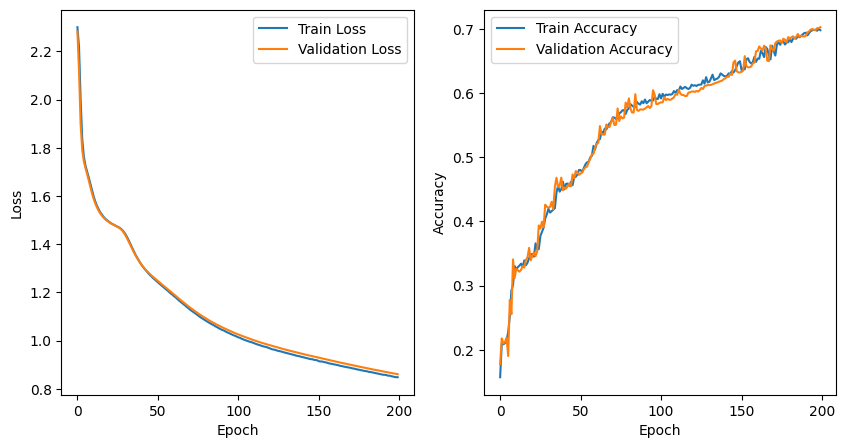

Adagrad done


Epoch [1/200], Train Loss: 1.727, Train Acc: 0.294, Val Loss: 1.306, Val Acc: 0.405


Epoch [2/200], Train Loss: 1.092, Train Acc: 0.516, Val Loss: 0.968, Val Acc: 0.599


Epoch [3/200], Train Loss: 0.834, Train Acc: 0.681, Val Loss: 0.800, Val Acc: 0.705


Epoch [4/200], Train Loss: 0.716, Train Acc: 0.737, Val Loss: 0.733, Val Acc: 0.748


Epoch [5/200], Train Loss: 0.649, Train Acc: 0.765, Val Loss: 0.722, Val Acc: 0.737


Epoch [6/200], Train Loss: 0.607, Train Acc: 0.777, Val Loss: 0.698, Val Acc: 0.745


Epoch [7/200], Train Loss: 0.573, Train Acc: 0.790, Val Loss: 0.635, Val Acc: 0.767


Epoch [8/200], Train Loss: 0.551, Train Acc: 0.796, Val Loss: 0.622, Val Acc: 0.773


Epoch [9/200], Train Loss: 0.528, Train Acc: 0.802, Val Loss: 0.609, Val Acc: 0.775


Epoch [10/200], Train Loss: 0.517, Train Acc: 0.807, Val Loss: 0.555, Val Acc: 0.794


Epoch [11/200], Train Loss: 0.501, Train Acc: 0.812, Val Loss: 0.593, Val Acc: 0.781


Epoch [12/200], Train Loss: 0.491, Train Acc: 0.816, Val Loss: 0.615, Val Acc: 0.768


Epoch [13/200], Train Loss: 0.479, Train Acc: 0.820, Val Loss: 0.508, Val Acc: 0.807


Epoch [14/200], Train Loss: 0.468, Train Acc: 0.824, Val Loss: 0.520, Val Acc: 0.803


Epoch [15/200], Train Loss: 0.458, Train Acc: 0.828, Val Loss: 0.541, Val Acc: 0.799


Epoch [16/200], Train Loss: 0.451, Train Acc: 0.831, Val Loss: 0.522, Val Acc: 0.806


Epoch [17/200], Train Loss: 0.440, Train Acc: 0.835, Val Loss: 0.491, Val Acc: 0.812


Epoch [18/200], Train Loss: 0.435, Train Acc: 0.835, Val Loss: 0.523, Val Acc: 0.800


Epoch [19/200], Train Loss: 0.427, Train Acc: 0.841, Val Loss: 0.469, Val Acc: 0.825


Epoch [20/200], Train Loss: 0.419, Train Acc: 0.844, Val Loss: 0.478, Val Acc: 0.823


Epoch [21/200], Train Loss: 0.414, Train Acc: 0.847, Val Loss: 0.474, Val Acc: 0.821


Epoch [22/200], Train Loss: 0.406, Train Acc: 0.850, Val Loss: 0.474, Val Acc: 0.820


Epoch [23/200], Train Loss: 0.398, Train Acc: 0.855, Val Loss: 0.445, Val Acc: 0.841


Epoch [24/200], Train Loss: 0.393, Train Acc: 0.857, Val Loss: 0.461, Val Acc: 0.829


Epoch [25/200], Train Loss: 0.389, Train Acc: 0.859, Val Loss: 0.444, Val Acc: 0.838


Epoch [26/200], Train Loss: 0.381, Train Acc: 0.862, Val Loss: 0.467, Val Acc: 0.823


Epoch [27/200], Train Loss: 0.375, Train Acc: 0.865, Val Loss: 0.436, Val Acc: 0.846


Epoch [28/200], Train Loss: 0.371, Train Acc: 0.866, Val Loss: 0.435, Val Acc: 0.843


Epoch [29/200], Train Loss: 0.364, Train Acc: 0.868, Val Loss: 0.416, Val Acc: 0.849


Epoch [30/200], Train Loss: 0.358, Train Acc: 0.870, Val Loss: 0.456, Val Acc: 0.829


Epoch [31/200], Train Loss: 0.354, Train Acc: 0.873, Val Loss: 0.403, Val Acc: 0.858


Epoch [32/200], Train Loss: 0.347, Train Acc: 0.874, Val Loss: 0.430, Val Acc: 0.848


Epoch [33/200], Train Loss: 0.345, Train Acc: 0.875, Val Loss: 0.431, Val Acc: 0.846


Epoch [34/200], Train Loss: 0.339, Train Acc: 0.877, Val Loss: 0.420, Val Acc: 0.852


Epoch [35/200], Train Loss: 0.335, Train Acc: 0.879, Val Loss: 0.395, Val Acc: 0.858


Epoch [36/200], Train Loss: 0.332, Train Acc: 0.882, Val Loss: 0.439, Val Acc: 0.843


Epoch [37/200], Train Loss: 0.327, Train Acc: 0.883, Val Loss: 0.391, Val Acc: 0.861


Epoch [38/200], Train Loss: 0.323, Train Acc: 0.884, Val Loss: 0.415, Val Acc: 0.852


Epoch [39/200], Train Loss: 0.322, Train Acc: 0.883, Val Loss: 0.392, Val Acc: 0.859


Epoch [40/200], Train Loss: 0.318, Train Acc: 0.888, Val Loss: 0.418, Val Acc: 0.852


Epoch [41/200], Train Loss: 0.314, Train Acc: 0.888, Val Loss: 0.429, Val Acc: 0.846


Epoch [42/200], Train Loss: 0.311, Train Acc: 0.888, Val Loss: 0.380, Val Acc: 0.867


Epoch [43/200], Train Loss: 0.307, Train Acc: 0.890, Val Loss: 0.386, Val Acc: 0.865


Epoch [44/200], Train Loss: 0.303, Train Acc: 0.892, Val Loss: 0.388, Val Acc: 0.863


Epoch [45/200], Train Loss: 0.302, Train Acc: 0.892, Val Loss: 0.388, Val Acc: 0.865


Epoch [46/200], Train Loss: 0.296, Train Acc: 0.894, Val Loss: 0.397, Val Acc: 0.858


Epoch [47/200], Train Loss: 0.296, Train Acc: 0.893, Val Loss: 0.388, Val Acc: 0.869
Early stopping at epoch 47


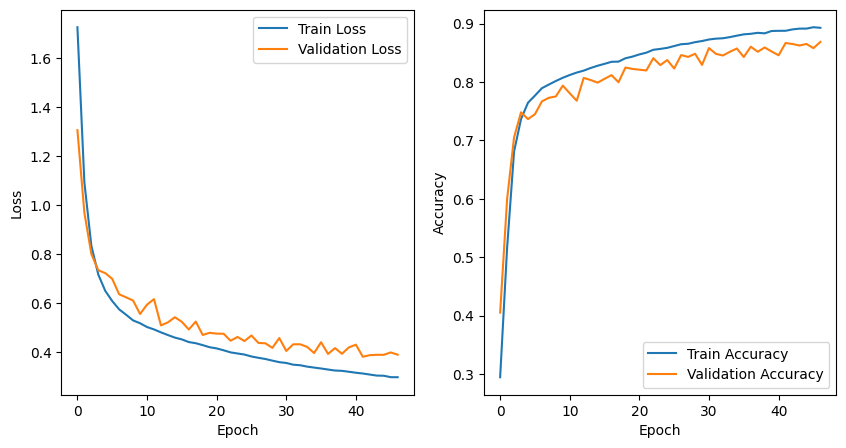

RMSprop done


Epoch [1/200], Train Loss: 1.943, Train Acc: 0.194, Val Loss: 1.598, Val Acc: 0.327


Epoch [2/200], Train Loss: 1.336, Train Acc: 0.407, Val Loss: 1.158, Val Acc: 0.502


Epoch [3/200], Train Loss: 1.025, Train Acc: 0.562, Val Loss: 0.912, Val Acc: 0.616


Epoch [4/200], Train Loss: 0.834, Train Acc: 0.660, Val Loss: 0.797, Val Acc: 0.674


Epoch [5/200], Train Loss: 0.727, Train Acc: 0.734, Val Loss: 0.701, Val Acc: 0.769


Epoch [6/200], Train Loss: 0.634, Train Acc: 0.784, Val Loss: 0.625, Val Acc: 0.781


Epoch [7/200], Train Loss: 0.555, Train Acc: 0.805, Val Loss: 0.558, Val Acc: 0.802


Epoch [8/200], Train Loss: 0.507, Train Acc: 0.818, Val Loss: 0.552, Val Acc: 0.801


Epoch [9/200], Train Loss: 0.481, Train Acc: 0.826, Val Loss: 0.501, Val Acc: 0.819


Epoch [10/200], Train Loss: 0.447, Train Acc: 0.841, Val Loss: 0.477, Val Acc: 0.834


Epoch [11/200], Train Loss: 0.412, Train Acc: 0.860, Val Loss: 0.443, Val Acc: 0.847


Epoch [12/200], Train Loss: 0.389, Train Acc: 0.867, Val Loss: 0.430, Val Acc: 0.852


Epoch [13/200], Train Loss: 0.373, Train Acc: 0.872, Val Loss: 0.416, Val Acc: 0.859


Epoch [14/200], Train Loss: 0.355, Train Acc: 0.879, Val Loss: 0.405, Val Acc: 0.858


Epoch [15/200], Train Loss: 0.344, Train Acc: 0.883, Val Loss: 0.399, Val Acc: 0.860


Epoch [16/200], Train Loss: 0.331, Train Acc: 0.886, Val Loss: 0.394, Val Acc: 0.863


Epoch [17/200], Train Loss: 0.326, Train Acc: 0.887, Val Loss: 0.393, Val Acc: 0.864


Epoch [18/200], Train Loss: 0.317, Train Acc: 0.890, Val Loss: 0.403, Val Acc: 0.859


Epoch [19/200], Train Loss: 0.311, Train Acc: 0.893, Val Loss: 0.390, Val Acc: 0.867


Epoch [20/200], Train Loss: 0.299, Train Acc: 0.896, Val Loss: 0.388, Val Acc: 0.867


Epoch [21/200], Train Loss: 0.296, Train Acc: 0.898, Val Loss: 0.381, Val Acc: 0.870


Epoch [22/200], Train Loss: 0.290, Train Acc: 0.899, Val Loss: 0.378, Val Acc: 0.871


Epoch [23/200], Train Loss: 0.285, Train Acc: 0.900, Val Loss: 0.387, Val Acc: 0.870


Epoch [24/200], Train Loss: 0.280, Train Acc: 0.902, Val Loss: 0.399, Val Acc: 0.863


Epoch [25/200], Train Loss: 0.272, Train Acc: 0.906, Val Loss: 0.378, Val Acc: 0.873


Epoch [26/200], Train Loss: 0.269, Train Acc: 0.906, Val Loss: 0.375, Val Acc: 0.875


Epoch [27/200], Train Loss: 0.267, Train Acc: 0.907, Val Loss: 0.373, Val Acc: 0.874


Epoch [28/200], Train Loss: 0.266, Train Acc: 0.907, Val Loss: 0.378, Val Acc: 0.872


Epoch [29/200], Train Loss: 0.259, Train Acc: 0.909, Val Loss: 0.371, Val Acc: 0.872


Epoch [30/200], Train Loss: 0.256, Train Acc: 0.911, Val Loss: 0.362, Val Acc: 0.875


Epoch [31/200], Train Loss: 0.251, Train Acc: 0.913, Val Loss: 0.375, Val Acc: 0.874


Epoch [32/200], Train Loss: 0.250, Train Acc: 0.912, Val Loss: 0.373, Val Acc: 0.874


Epoch [33/200], Train Loss: 0.245, Train Acc: 0.914, Val Loss: 0.363, Val Acc: 0.878


Epoch [34/200], Train Loss: 0.237, Train Acc: 0.919, Val Loss: 0.374, Val Acc: 0.877


Epoch [35/200], Train Loss: 0.237, Train Acc: 0.918, Val Loss: 0.381, Val Acc: 0.876
Early stopping at epoch 35


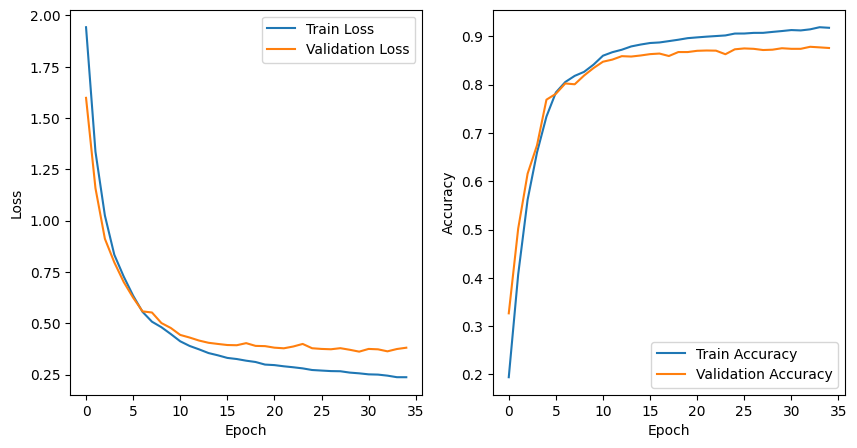

Adam done


Epoch [1/200], Train Loss: 1.882, Train Acc: 0.213, Val Loss: 1.437, Val Acc: 0.393


Epoch [2/200], Train Loss: 1.203, Train Acc: 0.459, Val Loss: 1.010, Val Acc: 0.571


Epoch [3/200], Train Loss: 0.838, Train Acc: 0.667, Val Loss: 0.720, Val Acc: 0.745


Epoch [4/200], Train Loss: 0.600, Train Acc: 0.806, Val Loss: 0.557, Val Acc: 0.824


Epoch [5/200], Train Loss: 0.483, Train Acc: 0.845, Val Loss: 0.498, Val Acc: 0.832


Epoch [6/200], Train Loss: 0.418, Train Acc: 0.864, Val Loss: 0.452, Val Acc: 0.846


Epoch [7/200], Train Loss: 0.382, Train Acc: 0.874, Val Loss: 0.432, Val Acc: 0.852


Epoch [8/200], Train Loss: 0.357, Train Acc: 0.882, Val Loss: 0.415, Val Acc: 0.858


Epoch [9/200], Train Loss: 0.342, Train Acc: 0.886, Val Loss: 0.398, Val Acc: 0.865


Epoch [10/200], Train Loss: 0.326, Train Acc: 0.890, Val Loss: 0.392, Val Acc: 0.870


Epoch [11/200], Train Loss: 0.312, Train Acc: 0.895, Val Loss: 0.391, Val Acc: 0.869


Epoch [12/200], Train Loss: 0.303, Train Acc: 0.898, Val Loss: 0.378, Val Acc: 0.872


Epoch [13/200], Train Loss: 0.292, Train Acc: 0.901, Val Loss: 0.381, Val Acc: 0.867


Epoch [14/200], Train Loss: 0.285, Train Acc: 0.903, Val Loss: 0.375, Val Acc: 0.874


Epoch [15/200], Train Loss: 0.276, Train Acc: 0.905, Val Loss: 0.382, Val Acc: 0.870


Epoch [16/200], Train Loss: 0.267, Train Acc: 0.909, Val Loss: 0.372, Val Acc: 0.877


Epoch [17/200], Train Loss: 0.259, Train Acc: 0.911, Val Loss: 0.372, Val Acc: 0.875


Epoch [18/200], Train Loss: 0.254, Train Acc: 0.912, Val Loss: 0.368, Val Acc: 0.877


Epoch [19/200], Train Loss: 0.246, Train Acc: 0.915, Val Loss: 0.371, Val Acc: 0.876


Epoch [20/200], Train Loss: 0.241, Train Acc: 0.916, Val Loss: 0.375, Val Acc: 0.873


Epoch [21/200], Train Loss: 0.233, Train Acc: 0.919, Val Loss: 0.373, Val Acc: 0.876


Epoch [22/200], Train Loss: 0.230, Train Acc: 0.920, Val Loss: 0.365, Val Acc: 0.878


Epoch [23/200], Train Loss: 0.225, Train Acc: 0.921, Val Loss: 0.363, Val Acc: 0.879


Epoch [24/200], Train Loss: 0.221, Train Acc: 0.922, Val Loss: 0.368, Val Acc: 0.878


Epoch [25/200], Train Loss: 0.217, Train Acc: 0.924, Val Loss: 0.371, Val Acc: 0.879


Epoch [26/200], Train Loss: 0.213, Train Acc: 0.926, Val Loss: 0.366, Val Acc: 0.879


Epoch [27/200], Train Loss: 0.206, Train Acc: 0.928, Val Loss: 0.395, Val Acc: 0.874


Epoch [28/200], Train Loss: 0.204, Train Acc: 0.928, Val Loss: 0.368, Val Acc: 0.881
Early stopping at epoch 28


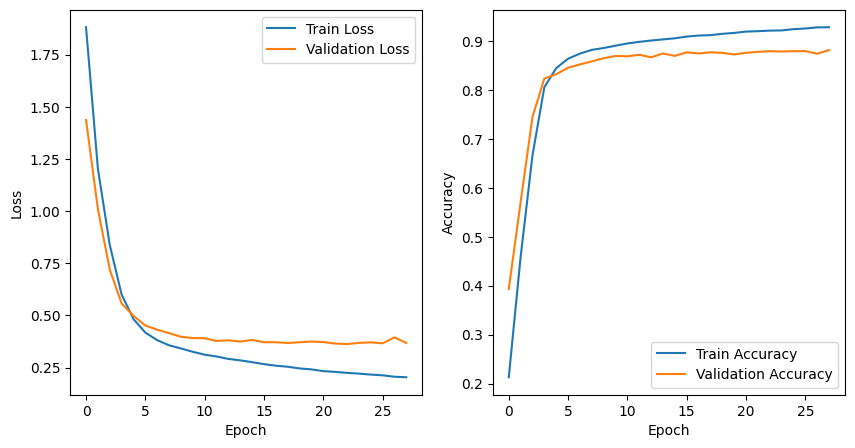

ADOPT done


In [17]:
lr = 0.001
for optim_name in optimizers:
    train_losses, train_acc, val_losses, val_acc = train(train_loader, test_loader, optim_name, num_epochs, lr, patience=5)
    plot(train_losses, train_acc, val_losses, val_acc)
    torch.save(train_losses, f'{optim_name}_train_losses.pt')
    torch.save(train_acc, f'{optim_name}_train_acc.pt')
    torch.save(val_losses, f'{optim_name}_val_losses.pt')
    torch.save(val_acc, f'{optim_name}_val_acc.pt')
    print(f'{optim_name} done')
    print('='*50)

<ipython-input-19-7ececad22144>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_losses = [torch.load(f'{optim_name}_train_losses.pt') for optim_name in optimizers]
<i

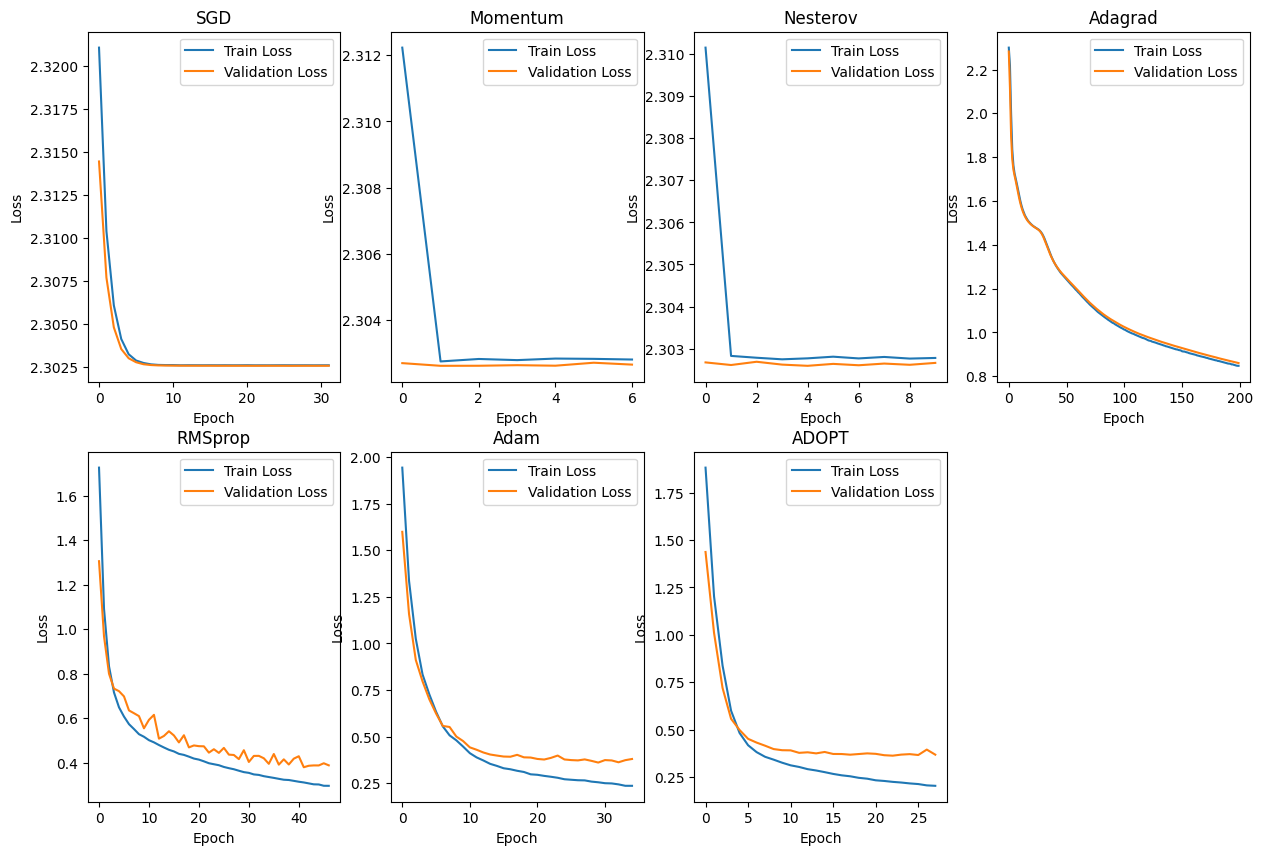

In [19]:
train_losses = [torch.load(f'{optim_name}_train_losses.pt') for optim_name in optimizers]
train_acc = [torch.load(f'{optim_name}_train_acc.pt') for optim_name in optimizers]
val_losses = [torch.load(f'{optim_name}_val_losses.pt') for optim_name in optimizers]
val_acc = [torch.load(f'{optim_name}_val_acc.pt') for optim_name in optimizers]

# plot losses and acc for each optim
plt.figure(figsize=(15, 10))
for i in range(len(optimizers)):
    plt.subplot(2, 4, i+1)
    plt.plot(train_losses[i], label='Train Loss')
    plt.plot(val_losses[i], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(optimizers[i])
    plt.legend()
plt.show()

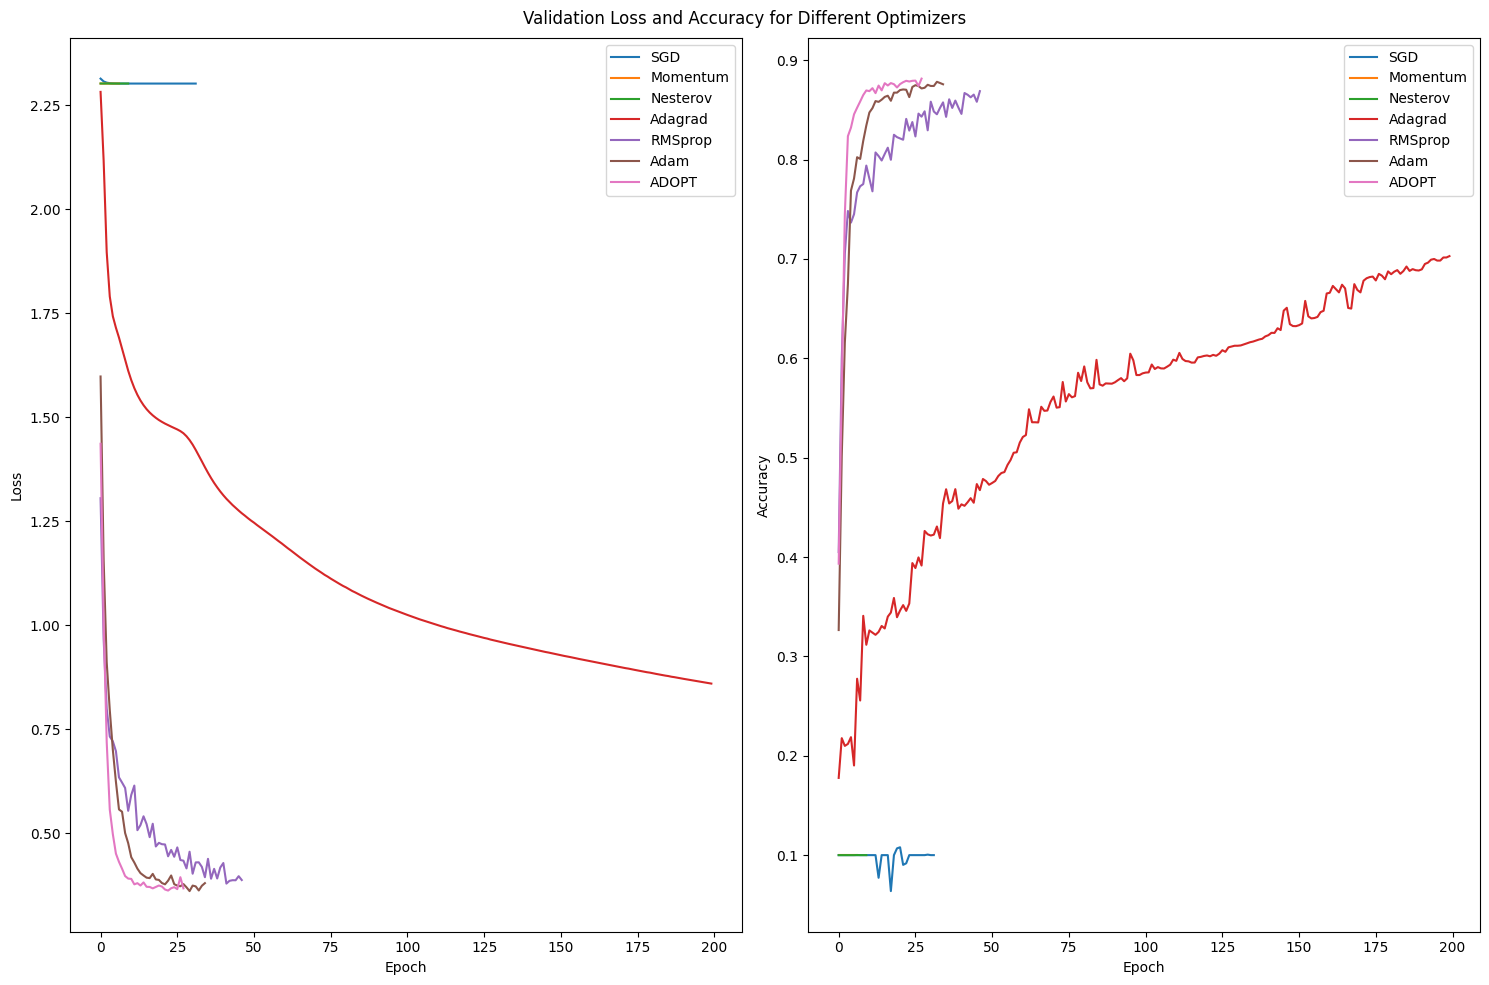

In [27]:
plt.figure(figsize=(15, 10))
for i in range(len(optimizers)):
    plt.subplot(1, 2, 1)
    plt.plot(val_losses[i], label=f'{optimizers[i]}')
    plt.subplot(1, 2, 2)
    plt.plot(val_acc[i], label=f'{optimizers[i]}')

plt.subplot(121)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle('Validation Loss and Accuracy for Different Optimizers')
plt.tight_layout()
plt.show()